# Workflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import mammos_analysis
import mammos_dft
import mammos_spindynamics
import mammos_mumag
import mammos_entity as me
import mammos_units as u

u.set_enabled_equivalencies(u.magnetic_flux_field())

## 1: DFT data: magnetisation and anisotropy at zero Kelvin

In [2]:
results_dft = mammos_dft.db.get_micromagnetic_properties("Nd2Fe14B-136", print_info=True)

Found material in database.

Chemical Formula: Nd2Fe14B
Space group name: P42/mnm
Space group number: 136
Cell length a: 8.78 Angstrom
Cell length b: 8.78 Angstrom
Cell length c: 12.12 Angstrom
Cell angle alpha: 90.0 deg
Cell angle beta: 90.0 deg
Cell angle gamma: 90.0 deg
Cell volume: 933.42 Angstrom
ICSD_label: 
OQMD_label:

The first step loads spontaneous magnetisation $M_s$ and the uniaxial anisotropy constant $K_1$ from a database of DFT calculations.

In [3]:
results_dft

MicromagneticProperties(Ms_0=SpontaneousMagnetization(value=1280000.0, unit=A / m), K1_0=UniaxialAnisotropyConstant(value=4300000.0, unit=J / m3))

In [4]:
results_dft.Ms_0

SpontaneousMagnetization(value=1280000.0, unit=A / m)

In [5]:
results_dft.K1_0

UniaxialAnisotropyConstant(value=4300000.0, unit=J / m3)

## 2: Temperature-dependent magnetisation data from spindynamics database lookup

In [6]:
magnetisation_data = mammos_spindynamics.db.get_spontaneous_magnetisation("Nd2Fe14B-136")

In the second step we use a spin dynamics calculation database. We load some points for the temperature-dependent magnetisation.

In [7]:
magnetisation_data.T

ThermodynamicTemperature(value=[  0.          31.57894737  63.15789474  94.73684211 126.31578947
 157.89473684 189.47368421 221.05263158 252.63157895 284.21052632
 315.78947368 347.36842105 378.94736842 410.52631579 442.10526316
 473.68421053 505.26315789 536.84210526 568.42105263 600.        ], unit=K)

In [8]:
magnetisation_data.Ms

SpontaneousMagnetization(value=[1460000.         1456985.36046193 1449449.93657199 1437972.77253639
 1422736.58364638 1403779.39648225 1381044.11152378 1354391.97626968
 1323600.99407897 1288353.67899904 1248213.31769096 1202584.11677895
 1150645.20320241 1091237.80552561 1022660.54963577  942263.95974459
  845538.33920183  723617.755767    553555.21471405  171781.14820705], unit=A / m)

In [9]:
mammos_spindynamics.db.get_spontaneous_magnetisation("Nd2Fe14B-136")

MagnetisationData(T=ThermodynamicTemperature(value=[  0.          31.57894737  63.15789474  94.73684211 126.31578947
 157.89473684 189.47368421 221.05263158 252.63157895 284.21052632
 315.78947368 347.36842105 378.94736842 410.52631579 442.10526316
 473.68421053 505.26315789 536.84210526 568.42105263 600.        ], unit=K), Ms=SpontaneousMagnetization(value=[1460000.         1456985.36046193 1449449.93657199 1437972.77253639
 1422736.58364638 1403779.39648225 1381044.11152378 1354391.97626968
 1323600.99407897 1288353.67899904 1248213.31769096 1202584.11677895
 1150645.20320241 1091237.80552561 1022660.54963577  942263.95974459
  845538.33920183  723617.755767    553555.21471405  171781.14820705], unit=A / m))

In [10]:
magnetisation_data.dataframe

,T,Ms
0,0.000000,1.460000e+06
1,31.578947,1.456985e+06
2,63.157895,1.449450e+06
3,94.736842,1.437973e+06
4,126.315789,1.422737e+06
5,157.894737,1.403779e+06
6,189.473684,1.381044e+06
7,221.052632,1.354392e+06
8,252.631579,1.323601e+06
9,284.210526,1.288354e+06


<Axes: xlabel='T'>

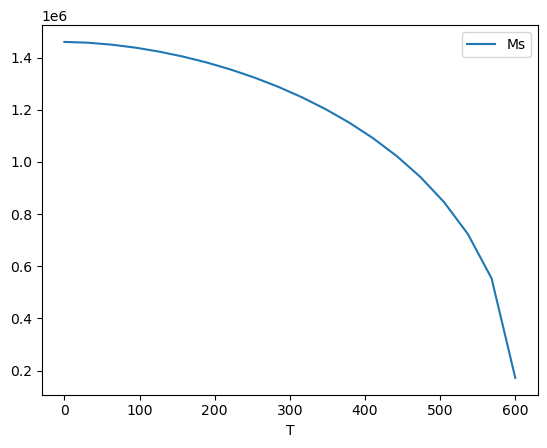

In [11]:
magnetisation_data.dataframe.plot(x="T")

## 3: Calculate micromagnetic intrinsic properties using Kuz'min formula

In [12]:
kuzmin_result = mammos_analysis.kuzmin_properties(
    T=magnetisation_data.T,
    Ms=magnetisation_data.Ms,
    K1_0=results_dft.K1_0
)

In [13]:
kuzmin_result

KuzminResult(Ms=Ms(T), A=A(T), K1=K1(T))

In [14]:
kuzmin_result.A, type(kuzmin_result.A)

(A(T), mammos_analysis.kuzmin._A_function_of_temperature)

In [15]:
kuzmin_result.K1, type(kuzmin_result.K1)

(K1(T), mammos_analysis.kuzmin._K1_function_of_temperature)

In [16]:
kuzmin_result.Ms, type(kuzmin_result.Ms)

(Ms(T), mammos_analysis.kuzmin._Ms_function_of_temperature)

In [17]:
T = me.Entity("ThermodynamicTemperature", value=300, unit="K")
T

ThermodynamicTemperature(value=300.0, unit=K)

In [18]:
kuzmin_result.Ms(T), type(kuzmin_result.Ms(T))

(SpontaneousMagnetization(value=1259264.694893875, unit=A / m),
 mammos_entity.base.Entity)

## 4: Run micromagnetic simulation - Evaluate hysteresis loop

In [19]:
loop_results = mammos_mumag.hysteresis.run(
    mesh_filepath=mammos_mumag.mesh.CUBE_20_nm,
    Ms=kuzmin_result.Ms(T),
    A=kuzmin_result.A(T),
    K1=kuzmin_result.K1(T),
    hstart=(7*u.T).to(u.A / u.m),
    hfinal=(-10*u.T).to(u.A / u.m),
    hnsteps=30,
)

The outputs from the hysteresis loop are:

In [20]:
loop_results.H

ExternalMagneticField(value=[ 5570423.00518393  5119484.00000238  4668544.99482082  4217605.98963926
  3766666.98445771  3315727.97927615  2864788.9740946   2413849.96891304
  1962910.96373148  1511971.95854993  1061032.95336837   610093.94818681
   159154.94300526  -291784.0621763   -742723.06735786 -1193662.07253941
 -1644601.07772097 -2095540.08290253 -2546479.08808408 -2997418.09326564], unit=A / m)

In [21]:
loop_results.H.ontology_label

'ExternalMagneticField'

In [22]:
loop_results.M

SpontaneousMagnetization(value=[ 1259072.54948708  1259052.82405831  1259029.88980012  1259003.00951291
  1258971.22082701  1258933.24832531  1258887.37253321  1258831.23005113
  1258761.49986538  1258673.39503963  1258559.80771452  1258409.80693536
  1258205.8557008   1257918.33169771  1257493.74506028  1256826.8856607
  1255684.14964104  1253440.5516389   1247685.52503741 -1258901.81208853], unit=A / m)

In [23]:
loop_results.energy_density

EnergyDensity(value=[-11263295.79682548 -10549826.80367321  -9836369.86694099
  -9122927.00480458  -8409500.71360436  -7696094.11871253
  -6982711.1865229   -6269357.02861117  -5556038.34863297
  -4842764.11703658  -4129546.62228879  -3416403.17028152
  -2703358.95502994  -1990452.17392177  -1277743.76972834
   -565337.64884598    146572.15808256    857570.6657998
   1566526.87122736  -7192526.9637194 ], unit=J / m3)

The `dataframe` property generates a dataframe in the SI units ($\mathrm{A}/\mathrm{m}$ for external magnetic field and spontaneous magnetisation).

In [24]:
loop_results.dataframe

,configuration_type,H,M,energy_density
0,1,5.570423e+06,1.259073e+06,-1.126330e+07
1,1,5.119484e+06,1.259053e+06,-1.054983e+07
2,1,4.668545e+06,1.259030e+06,-9.836370e+06
3,1,4.217606e+06,1.259003e+06,-9.122927e+06
4,1,3.766667e+06,1.258971e+06,-8.409501e+06
5,1,3.315728e+06,1.258933e+06,-7.696094e+06
6,1,2.864789e+06,1.258887e+06,-6.982711e+06
7,1,2.413850e+06,1.258831e+06,-6.269357e+06
8,1,1.962911e+06,1.258761e+06,-5.556038e+06
9,1,1.511972e+06,1.258673e+06,-4.842764e+06


We can generate a table in Tesla:

In [25]:
df = pd.DataFrame(
    {
        "mu0_H": loop_results.H.to(u.T),
        "J": loop_results.M.to(u.T),
    }
)
df

,mu0_H,J
0,7.000000,1.582197
1,6.433333,1.582172
2,5.866667,1.582144
3,5.300000,1.582110
4,4.733333,1.582070
5,4.166667,1.582022
6,3.600000,1.581965
7,3.033333,1.581894
8,2.466667,1.581806
9,1.900000,1.581696


In [26]:
# INFO: useful information
# df["H"] = (df["mu0_Hext"].to_numpy() * u.T).to("A/m")
# df["M"] = (df["polarisation"].to_numpy() * u.T).to("A/m").value
df * u.T.to("A/m")

,mu0_H,J
0,5.570423e+06,1.259073e+06
1,5.119484e+06,1.259053e+06
2,4.668545e+06,1.259030e+06
3,4.217606e+06,1.259003e+06
4,3.766667e+06,1.258971e+06
5,3.315728e+06,1.258933e+06
6,2.864789e+06,1.258887e+06
7,2.413850e+06,1.258831e+06
8,1.962911e+06,1.258761e+06
9,1.511972e+06,1.258673e+06


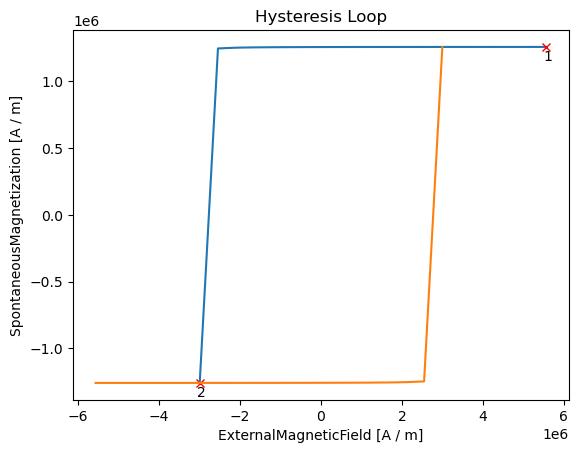

In [27]:
loop_results.plot(duplicate=True, configuration_marks=True)

In [28]:
loop_results.configurations

[PosixPath('/home/petrocch/Seafile/programming/mammos/workflow/8/hystloop/hystloop_0001.vtu'),
 PosixPath('/home/petrocch/Seafile/programming/mammos/workflow/8/hystloop/hystloop_0002.vtu')]

In [29]:
loop_results.plot_configuration(0)

Widget(value='<iframe src="http://localhost:44425/index.html?ui=P_0x7f37a6260690_0&reconnect=auto" class="pyvi…

We can extract the extrinsic properties with the `extrinsic_properties` function from the `mammos_analysis` package:

In [30]:
extrinsic_properties = mammos_analysis.hysteresis.extrinsic_properties(
    loop_results.M,
    loop_results.H,
    demagnetisation_coefficient=None,
)

In [31]:
extrinsic_properties.Hc

CoercivityHcExternal(value=-1257918.3316977078, unit=A / m)

In [32]:
extrinsic_properties.Mr

Remanence(value=-2997418.0932656387, unit=A / m)

In [33]:
extrinsic_properties.BHmax
# is Not A Number (not yet implemented).

MaximumEnergyProduct(value=nan, unit=J / m3)

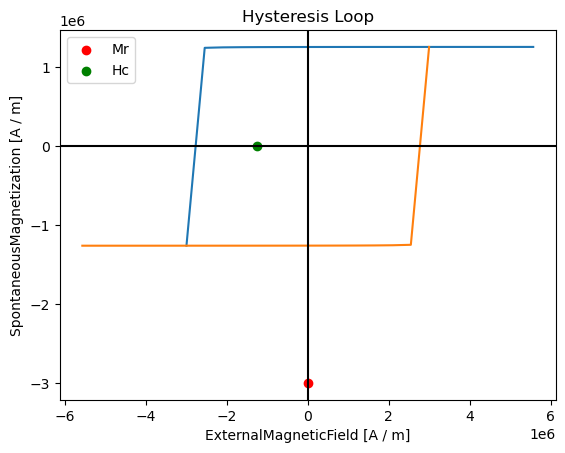

In [34]:
loop_results.plot()
plt.axhline(0, c="k")
plt.axvline(0, c="k")
plt.scatter([0],[extrinsic_properties.Mr.value], c="r", label="Mr")
plt.scatter(extrinsic_properties.Hc.value, 0, c="g", label="Hc")
plt.legend()